In [26]:
import sys
import warnings
from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import scipy.stats as stats
from scipy.stats import randint, uniform
import statsmodels.api as sm

from rich.console import Console
from rich.table import Table
from rich.live import Live
from rich import box

from sklearn.model_selection import train_test_split, KFold, cross_val_score, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error, make_scorer

import xgboost as xgb
from catboost import CatBoostRegressor

### Câu 1. Giá thuê phòng trọ thay đổi như thế nào giữa các quận khác nhau ở TP.HCM?


Thong ke gia thue theo quan (Trieu dong):
                 count  mean  median   min   max
district                                        
Quận Bình Thạnh   3098  4.68     4.8  0.75  27.0
Quận 10           1057  4.09     4.5  0.60  12.0
Quận Phú Nhuận     871  4.45     4.5  0.70  13.5
Quận 7            1304  4.11     4.0  0.65  13.0
Quận Tân Bình     2828  4.00     4.0  0.35  29.0
Quận Gò Vấp       2223  3.56     3.6  0.50  28.0
Quận Tân Phú      1688  3.60     3.6  0.50  23.0
Quận 9            1009  3.19     3.3  0.10  20.0
Quận 12           1065  2.99     3.0  0.60  10.5
Quận Bình Tân     1053  3.00     3.0  0.75  10.0


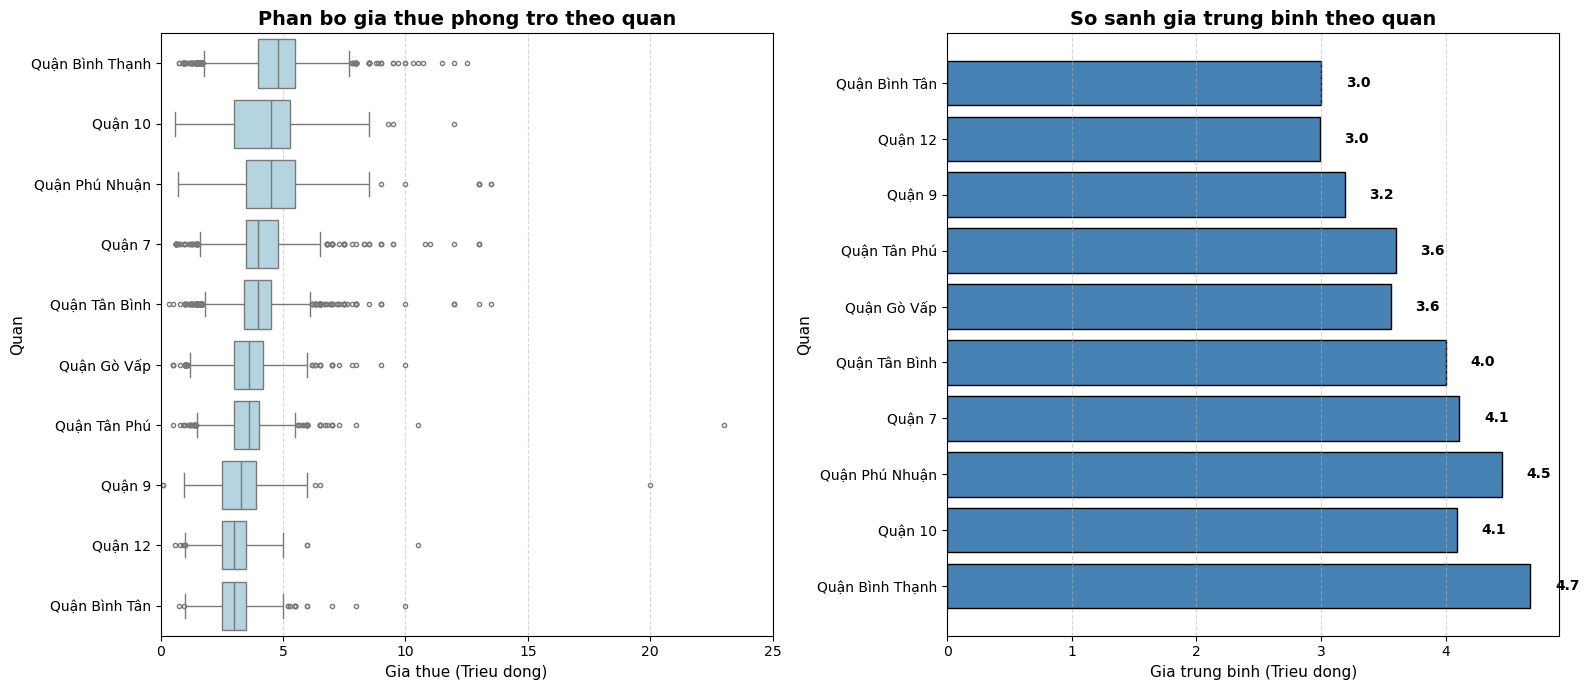


=> Quan co gia cao nhat: Quận Bình Thạnh (4.80 trieu)
=> Quan co gia thap nhat: Quận Bình Tân (3.00 trieu)


In [27]:
df = pd.read_csv("../Data/cleaned.csv")
df = df.drop(columns=['title', 'description', 'url'])

# Tách tên quận từ cột address
df['district'] = df['address'].apply(lambda x: x.split(' - ')[0] if isinstance(x, str) else x)

# Lọc top 10 quận có nhiều tin đăng nhất
top_districts = df['district'].value_counts().nlargest(10).index
df_filtered = df[df['district'].isin(top_districts)].copy()

# Loại bỏ outliers cực đoan (giá > 30 triệu, có thể là lỗi dữ liệu)
df_clean = df_filtered[df_filtered['price'] <= 30].copy()

# Tính thống kê giá thuê theo quận
price_stats = df_clean.groupby('district')['price'].agg([
    ('count', 'count'),
    ('mean', 'mean'),
    ('median', 'median'),
    ('min', 'min'),
    ('max', 'max')
]).sort_values('median', ascending=False).round(2)

print("\nThong ke gia thue theo quan (Trieu dong):")
print(price_stats)

fig, axes = plt.subplots(1, 2, figsize=(16, 7))

# 1. Boxplot - Phân bố giá
sns.boxplot(data=df_clean, x='price', y='district', 
            order=price_stats.index, color='lightblue', 
            showfliers=True, fliersize=3, ax=axes[0])
axes[0].set_title('Phan bo gia thue phong tro theo quan', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Gia thue (Trieu dong)', fontsize=11)
axes[0].set_ylabel('Quan', fontsize=11)
axes[0].set_xlim(0, 25)
axes[0].grid(axis='x', linestyle='--', alpha=0.5)

# 2. Biểu đồ cột - So sánh giá trung bình
bars = axes[1].barh(price_stats.index, price_stats['mean'], color='steelblue', edgecolor='black')
axes[1].set_title('So sanh gia trung binh theo quan', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Gia trung binh (Trieu dong)', fontsize=11)
axes[1].set_ylabel('Quan', fontsize=11)
axes[1].grid(axis='x', linestyle='--', alpha=0.5)

for i, (idx, val) in enumerate(price_stats['mean'].items()):
    axes[1].text(val + 0.2, i, f'{val:.1f}', va='center', fontsize=10, fontweight='bold')

plt.tight_layout()
plt.show()

print(f"\n=> Quan co gia cao nhat: {price_stats.index[0]} ({price_stats.iloc[0]['median']:.2f} trieu)")
print(f"=> Quan co gia thap nhat: {price_stats.index[-1]} ({price_stats.iloc[-1]['median']:.2f} trieu)")

Dựa trên dữ liệu thu thập được từ 10 quận, ta thấy có sự phân hóa rõ rệt về mức giá thuê phòng trọ, phản ánh vị trí địa lý và mức độ phát triển của từng khu vực. Cụ thể:

### 1. Phân cấp nhóm giá theo khu vực

Có thể chia các quận thành 3 nhóm giá thuê chính dựa trên mức trung vị (median):

**Nhóm giá cao (Trung vị từ 4.5 - 4.8 triệu/tháng):**
- Dẫn đầu là Quận Bình Thạnh với mức giá trung vị cao nhất (4.8 triệu) và cũng là quận có số lượng tin đăng nhiều nhất (3098 tin), cho thấy đây là "điểm nóng" về nhu cầu nhà ở.
- Tiếp theo là Quận Phú Nhuận và Quận 10 cùng mức trung vị 4.5 triệu. Đây là các quận trung tâm hoặc sát trung tâm, thuận tiện giao thông nên mặt bằng giá được thiết lập ở mức cao.

**Nhóm giá trung bình (Trung vị từ 3.6 - 4.0 triệu/tháng):**
- Bao gồm Quận 7 và Quận Tân Bình (4.0 triệu), theo sau là Quận Gò Vấp và Quận Tân Phú (3.6 triệu).
- Đây là phân khúc sôi động với lượng dữ liệu lớn (đặc biệt là Tân Bình và Gò Vấp), phù hợp với đại đa số người đi làm và sinh viên có thu nhập khá.

**Nhóm giá rẻ (Trung vị từ 3.0 - 3.3 triệu/tháng):**
- Gồm Quận 9 (3.3 triệu), Quận 12 và Quận Bình Tân (3.0 triệu).
- Đây là các quận vùng ven, xa trung tâm hơn, phù hợp cho đối tượng ưu tiên tiết kiệm chi phí. Chênh lệch giá trung vị giữa quận cao nhất (Bình Thạnh) và thấp nhất (Bình Tân) lên tới 1.8 triệu đồng/tháng.

### 2. Sự biến động giá (Độ phân tán dữ liệu)

Biểu đồ Boxplot cho thấy sự đa dạng về loại hình phòng trọ trong cùng một quận:

**Biên độ dao động lớn nhất:**
- Quận Tân Bình và Quận Gò Vấp tuy có giá trung bình thuộc nhóm giữa, nhưng lại ghi nhận các giá trị ngoại lai (outliers) cực lớn (Max lần lượt là 29 triệu và 28 triệu). Điều này cho thấy tại đây tồn tại song song cả phân khúc phòng trọ bình dân và các căn hộ dịch vụ cao cấp.

**Biên độ dao động ổn định:**
- Các quận như Quận 12 hay Bình Tân có hộp (box) ngắn hơn và ít điểm ngoại lai đột biến hơn, cho thấy giá thuê tại đây khá đồng đều và tập trung chủ yếu ở phân khúc bình dân.

**Trường hợp Quận 9:**
- Mặc dù giá trung vị thấp (3.3 triệu) nhưng khoảng giá trải rất rộng (từ 0.1 triệu đến 20 triệu), phản ánh sự pha trộn giữa các khu trọ sinh viên giá rẻ (Làng đại học) và các khu căn hộ cao cấp mới nổi.

### 3. Kết luận

Giá thuê phòng trọ tại TP.HCM không đồng nhất mà giảm dần từ các quận trung tâm/sát trung tâm ra phía ngoại thành. Quận Bình Thạnh là khu vực đắt đỏ và sầm uất nhất, trong khi Quận Bình Tân và Quận 12 là lựa chọn tối ưu về chi phí. Đáng chú ý, các quận như Tân Bình hay Gò Vấp cung cấp sự lựa chọn đa dạng nhất, đáp ứng được cả nhu cầu bình dân lẫn cao cấp.

### 2. Tiện nghi nào là ranh giới để phân biệt 2 loại phòng bình dân và cao cấp?

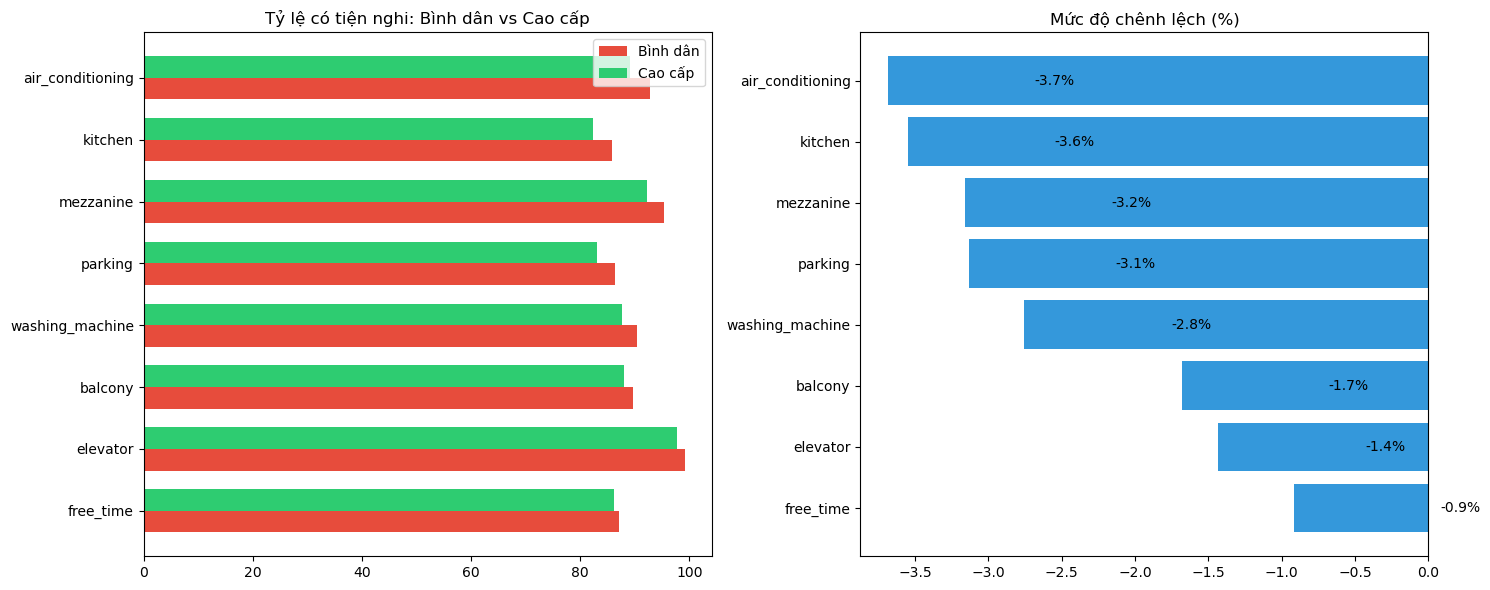

Ngưỡng giá phân loại:
- Bình dân: < 2.9 triệu
- Cao cấp: > 4.6 triệu

Top 5 tiện nghi phân biệt rõ nhất:
free_time         -0.916501
elevator          -1.433288
balcony           -1.682193
washing_machine   -2.754559
parking           -3.134497
Name: Chenh lech, dtype: float64


In [28]:
exclude_cols = ['title', 'price', 'area', 'address', 'description', 'url', 'district', 'ward', 'phone', 'author_name', 'time']
amenity_cols = [col for col in df.columns if col not in exclude_cols and df[col].dtype in ['int64', 'float64', 'bool']]

# 2. Phân loại phòng 
q25 = df['price'].quantile(0.25)
q75 = df['price'].quantile(0.75)

df['loai_phong'] = pd.cut(df['price'], 
                           bins=[-1, q25, q75, float('inf')], 
                           labels=['Binh dan', 'Trung cap', 'Cao cap'])

# 3. Tính toán tỷ lệ
amenity_comparison = pd.DataFrame()
for amenity in amenity_cols:
    rates = df.groupby('loai_phong', observed=False)[amenity].mean() * 100 
    amenity_comparison[amenity] = rates

amenity_comparison = amenity_comparison.T
# Tính chênh lệch
if 'Cao cap' in amenity_comparison.columns and 'Binh dan' in amenity_comparison.columns:
    amenity_comparison['Chenh lech'] = amenity_comparison['Cao cap'] - amenity_comparison['Binh dan']

top_diff = amenity_comparison['Chenh lech'].sort_values(ascending=False).head(10)
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

# Chart 1: So sánh trực tiếp
top_amenities = top_diff.index[:8]
data_plot = amenity_comparison.loc[top_amenities, ['Binh dan', 'Cao cap']]
x = np.arange(len(top_amenities))
width = 0.35

axes[0].barh(x - width/2, data_plot['Binh dan'], width, label='Bình dân', color='#e74c3c')
axes[0].barh(x + width/2, data_plot['Cao cap'], width, label='Cao cấp', color='#2ecc71')
axes[0].set_yticks(x)
axes[0].set_yticklabels(top_amenities)
axes[0].set_title('Tỷ lệ có tiện nghi: Bình dân vs Cao cấp')
axes[0].legend()

# Chart 2: Độ chênh lệch
axes[1].barh(top_diff.index[:8], top_diff.values[:8], color='#3498db')
axes[1].set_title('Mức độ chênh lệch (%)')
for i, v in enumerate(top_diff.values[:8]):
    axes[1].text(v + 1, i, f'{v:.1f}%', va='center')

plt.tight_layout()
plt.show()

print("Ngưỡng giá phân loại:")
print(f"- Bình dân: < {q25} triệu")
print(f"- Cao cấp: > {q75} triệu")
print("\nTop 5 tiện nghi phân biệt rõ nhất:")
print(top_diff.head(5))

## Câu hỏi 5: Liệu có yếu Tố Mùa Vụ Trong Giá Thuê Phòng Trọ tại TP.HCM?
**Cụ thể:** **Giá thuê phòng trọ tại TP.HCM có sự thay đổi theo các tháng trong năm hay không?**

Tập trung làm rõ:
* Có tồn tại tháng nào ghi nhận mức giá thuê cao hơn đáng kể so với các tháng còn lại hay không?
* Các biến động này có phản ánh yếu tố **mùa vụ (seasonality)** của thị trường bất động sản cho thuê hay không?

#### 2. Lợi ích của việc tìm ra câu trả lời
Việc xác định sự biến động giá thuê theo thời gian mang lại những giá trị thực tiễn sau:

* **Đối với người thuê nhà:** Lựa chọn được "thời điểm vàng" để thuê trọ với chi phí tối ưu nhất.
* **Đối với chủ nhà/Người đăng tin:** Có cơ sở dữ liệu để điều chỉnh mức giá cạnh tranh và phù hợp với nhu cầu thị trường tại từng thời điểm.
* **Cái nhìn sâu sắc về thị trường:** Hiểu rõ các động lực thúc đẩy giá (ví dụ: mùa nhập học của sinh viên vào tháng 8-9 hoặc làn sóng di cư lao động sau Tết).
* **Về mặt kỹ thuật (Data Science):** 
    * Cải thiện quá trình **Xây dựng đặc trưng (Feature Engineering)** bằng cách thêm các biến thời gian.
    * Tăng độ chính xác cho các mô hình dự báo giá (Predictive Models) nhờ xử lý được tính mùa vụ.

### 3. Phương pháp phân tích dữ liệu
Để trả lời câu hỏi trên, quy trình phân tích sẽ được thực hiện qua các bước:

#### Bước 1: Tiền xử lý và Trích xuất đặc trưng
* Chuyển đổi dữ liệu ngày đăng tin sang định dạng `datetime`.
* Trích xuất các thuộc tính: **Tháng (Month)**, **Quý (Quarter)**, hoặc **Mùa trong năm**.

#### Bước 2: Thống kê mô tả và Nhóm dữ liệu
* Sử dụng phương pháp **Groupby** theo tháng.
* Tính toán các chỉ số đại diện:
    * **Giá trung vị (Median Price):** Hạn chế ảnh hưởng của các giá trị cực đoan (outliers).
    * **Giá trên mỗi mét vuông ($Price/m^2$):** Giúp so sánh công bằng giữa các loại diện tích khác nhau.

#### Bước 3: Phân tích xu hướng (Visual Analysis)
* Sử dụng biểu đồ đường (Line chart) hoặc biểu đồ cột (Bar chart) để quan sát sự biến đổi qua 12 tháng.
* 

#### Bước 4: Kiểm soát biến gây nhiễu
* Phân tách dữ liệu theo từng **Quận/Huyện** để đảm bảo biến động giá là do yếu tố thời gian chứ không phải do sự thay đổi về tỷ lệ tin đăng giữa các khu vực.
* So sánh các đặc điểm phòng (nội thất, loại hình) để đảm bảo tính đồng nhất khi diễn giải kết quả.

## Model XG Boost

### Load Data

In [29]:
df = pd.read_csv("..\Data\processed.csv")
print(df.head())

         street_name  price  area  air_conditioning  fridge  washing_machine  \
0          Phạm Hùng    2.8  30.0                 1       1                1   
1  Nguyễn Lương Bằng    1.3  15.0                 1       1                1   
2         Thành Thái    4.5  25.0                 1       1                1   
3               Số 8    1.2  30.0                 1       1                1   
4       Phạm Ngũ Lão    1.5  30.0                 1       1                1   

   mezzanine  kitchen  wardrobe  bed  ...  parking  month  district  \
0          1        1         0    1  ...        1     11    Quận 8   
1          1        1         1    1  ...        1     11    Quận 7   
2          1        1         0    0  ...        1     11   Quận 10   
3          1        1         1    1  ...        1     11   Thủ Đức   
4          1        1         0    1  ...        1     11    Quận 1   

   price_per_m2   latitude   longitude  dist_to_q1_km  district_median_price  \
0      0.093

<>:1: SyntaxWarning: invalid escape sequence '\D'
<>:1: SyntaxWarning: invalid escape sequence '\D'
C:\Users\ADMIN\AppData\Local\Temp\ipykernel_24708\2076864160.py:1: SyntaxWarning: invalid escape sequence '\D'
  df = pd.read_csv("..\Data\processed.csv")


### Data Preparation

In [30]:
dropped = [
    "price",
]

X = df.drop(columns=dropped)
y = np.log1p(df["price"])

numerical_cols = X.select_dtypes(include=["float64"]).columns.tolist()
categorical_cols = X.select_dtypes(include=["object", "category", "bool", "int64"]).columns.tolist()

### Splitting Train/Validation/Test

In [31]:
X_Train_xgb, X_test_xgb, y_Train_xgb, y_test_xgb = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    shuffle=True
)
X_train_xgb, X_val_xgb, y_train_xgb, y_val_xgb = train_test_split(
    X_Train_xgb, y_Train_xgb,
    test_size=0.2,
    random_state=42,
    shuffle=True
)

### Encode Categorical

In [32]:
# Create copies
X_train_encoded = X_train_xgb.copy()
X_val_encoded = X_val_xgb.copy()
X_test_encoded = X_test_xgb.copy()

# MONTH - Cyclical encoding
X_train_encoded['month_sin'] = np.sin(2 * np.pi * X_train_encoded['month'] / 12)
X_train_encoded['month_cos'] = np.cos(2 * np.pi * X_train_encoded['month'] / 12)

X_val_encoded['month_sin'] = np.sin(2 * np.pi * X_val_encoded['month'] / 12)
X_val_encoded['month_cos'] = np.cos(2 * np.pi * X_val_encoded['month'] / 12)

X_test_encoded['month_sin'] = np.sin(2 * np.pi * X_test_encoded['month'] / 12)
X_test_encoded['month_cos'] = np.cos(2 * np.pi * X_test_encoded['month'] / 12)

X_train_encoded = X_train_encoded.drop('month', axis=1)
X_val_encoded = X_val_encoded.drop('month', axis=1)
X_test_encoded = X_test_encoded.drop('month', axis=1)

# DISTRICT - Label Encoding
le_district = LabelEncoder()
X_train_encoded['district'] = le_district.fit_transform(X_train_encoded['district'])
X_val_encoded['district'] = le_district.transform(X_val_encoded['district'])
X_test_encoded['district'] = le_district.transform(X_test_encoded['district'])

# STREET_NAME - Target Encoding
# Calculate mean target per street
street_means = X_train_xgb.join(y_train_xgb.rename('target')).groupby('street_name')['target'].mean()
global_mean = y_train_xgb.mean()

# Smoothing to avoid overfitting
smoothing = 10
street_counts = X_train_xgb['street_name'].value_counts()
street_encoded = (street_means * street_counts + global_mean * smoothing) / (street_counts + smoothing)

X_train_encoded['street_name'] = X_train_encoded['street_name'].map(street_encoded).fillna(global_mean)
X_val_encoded['street_name'] = X_val_encoded['street_name'].map(street_encoded).fillna(global_mean)
X_test_encoded['street_name'] = X_test_encoded['street_name'].map(street_encoded).fillna(global_mean)

### Train

In [33]:
xgb_model = xgb.XGBRegressor(
    n_estimators=1000,
    learning_rate=0.05,
    max_depth=6,
    min_child_weight=1,
    subsample=0.8,
    colsample_bytree=0.8,
    gamma=0,
    reg_alpha=0.1,
    reg_lambda=1,
    random_state=42,
    n_jobs=-1,
    early_stopping_rounds=50
)

print("\nTraining model...")
xgb_model.fit(
    X_train_encoded, y_train_xgb,
    eval_set=[(X_train_encoded, y_train_xgb), (X_val_encoded, y_val_xgb)],
    verbose=100
)

print(f"\nTraining completed!")
print(f"Best iteration: {xgb_model.best_iteration}")
print(f"Best score: {xgb_model.best_score:.4f}")


Training model...
[0]	validation_0-rmse:0.28954	validation_1-rmse:0.28785
[100]	validation_0-rmse:0.03647	validation_1-rmse:0.05770
[200]	validation_0-rmse:0.02688	validation_1-rmse:0.05589
[297]	validation_0-rmse:0.02199	validation_1-rmse:0.05598

Training completed!
Best iteration: 247
Best score: 0.0558


### Predict

In [34]:
y_pred_train = xgb_model.predict(X_train_encoded)
y_pred_val = xgb_model.predict(X_val_encoded)
y_pred_test = xgb_model.predict(X_test_encoded)

# Convert back to original scale
y_pred_train_original = np.expm1(y_pred_train)
y_pred_val_original = np.expm1(y_pred_val)
y_pred_test_original = np.expm1(y_pred_test)

y_train_original = np.expm1(y_train_xgb)
y_val_original = np.expm1(y_val_xgb)
y_test_original = np.expm1(y_test_xgb)

### Evaluate

In [35]:
def evaluate_model(y_true, y_pred, dataset_name):
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    
    print(f"\n{dataset_name}:")
    print(f"  RMSE: {rmse:.2f} triệu VNĐ")
    print(f"  MAE:  {mae:.2f} triệu VNĐ")
    print(f"  R²:   {r2:.4f}")
    print(f"  MAPE: {mape:.2f}%")
    
    return {'RMSE': rmse, 'MAE': mae, 'R2': r2, 'MAPE': mape}

train_metrics = evaluate_model(y_train_original, y_pred_train_original, "TRAIN SET")
val_metrics = evaluate_model(y_val_original, y_pred_val_original, "VALIDATION SET")
test_metrics = evaluate_model(y_test_original, y_pred_test_original, "TEST SET")


TRAIN SET:
  RMSE: 0.24 triệu VNĐ
  MAE:  0.05 triệu VNĐ
  R²:   0.9776
  MAPE: 1.38%

VALIDATION SET:
  RMSE: 0.51 triệu VNĐ
  MAE:  0.09 triệu VNĐ
  R²:   0.8762
  MAPE: 2.27%

TEST SET:
  RMSE: 0.60 triệu VNĐ
  MAE:  0.09 triệu VNĐ
  R²:   0.8628
  MAPE: 2.35%


### Feature Importance

In [36]:
print("\n" + "="*50)
print("FEATURE IMPORTANCE")
print("="*50)

feature_importance = pd.DataFrame({
    'feature': X_train_encoded.columns,
    'importance': xgb_model.feature_importances_
}).sort_values('importance', ascending=False)

print("\nTop 15 Most Important Features:")
print(feature_importance.head(15).to_string(index=False))


FEATURE IMPORTANCE

Top 15 Most Important Features:
              feature  importance
         price_per_m2    0.440410
                 area    0.340423
district_median_price    0.041373
          street_name    0.029499
        dist_to_q1_km    0.016445
            longitude    0.015660
              balcony    0.014949
             wardrobe    0.013500
             latitude    0.012319
        is_hot_street    0.009485
        amenity_ratio    0.007869
             district    0.007667
            month_cos    0.006448
     air_conditioning    0.006394
            mezzanine    0.005751


### Visualize

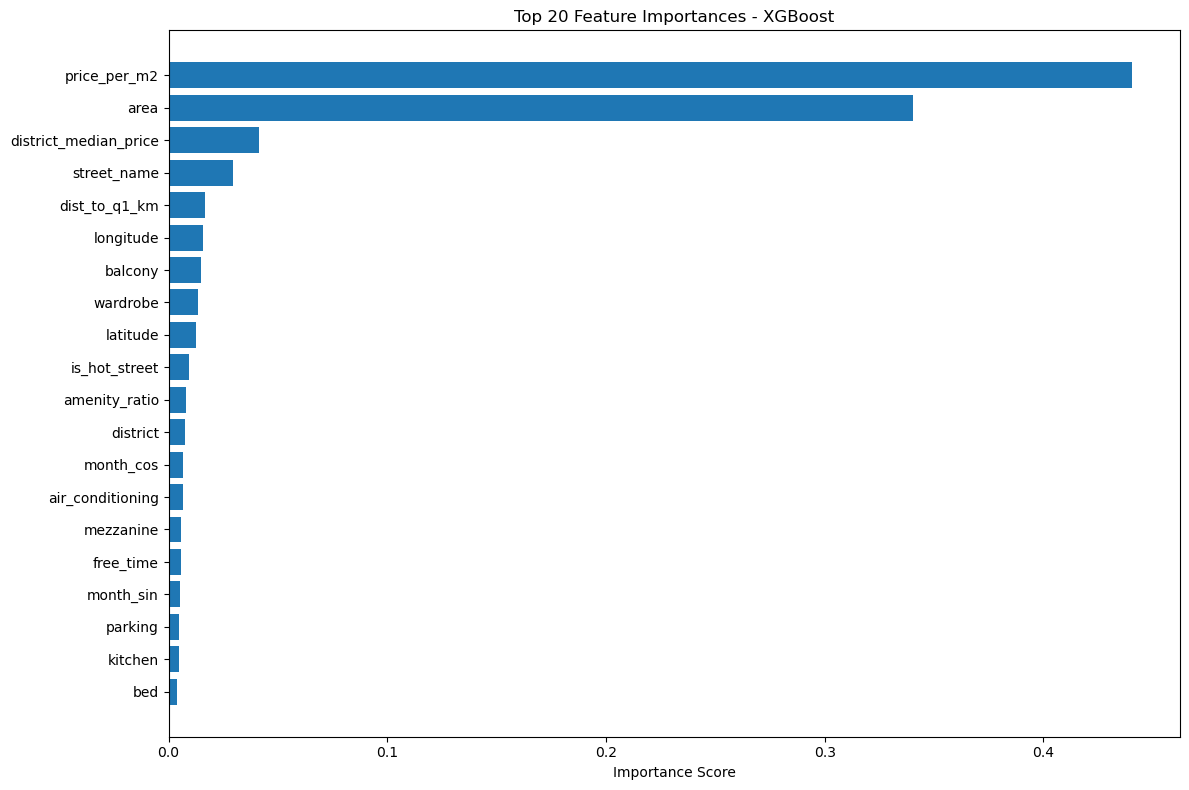

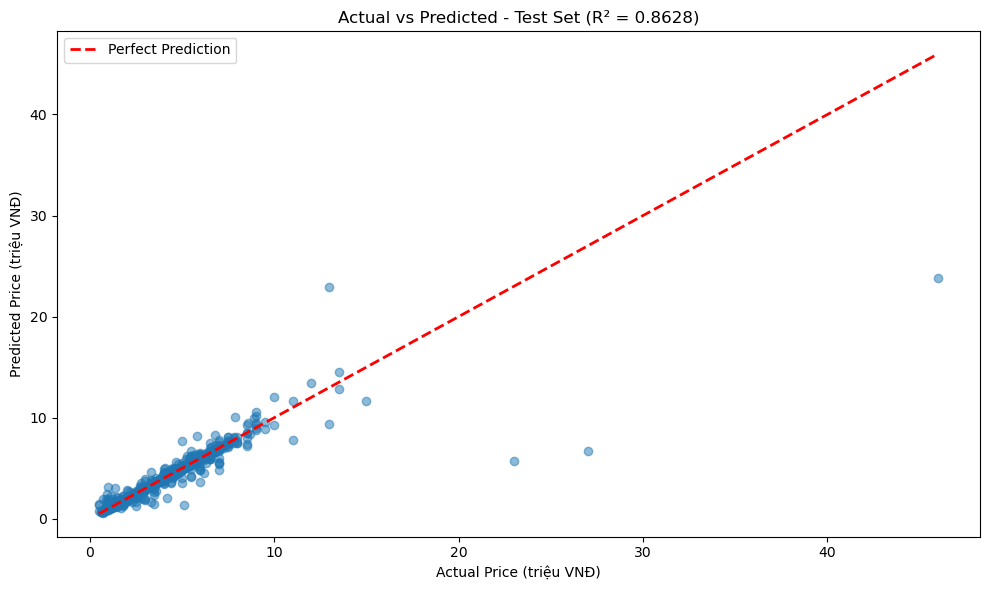

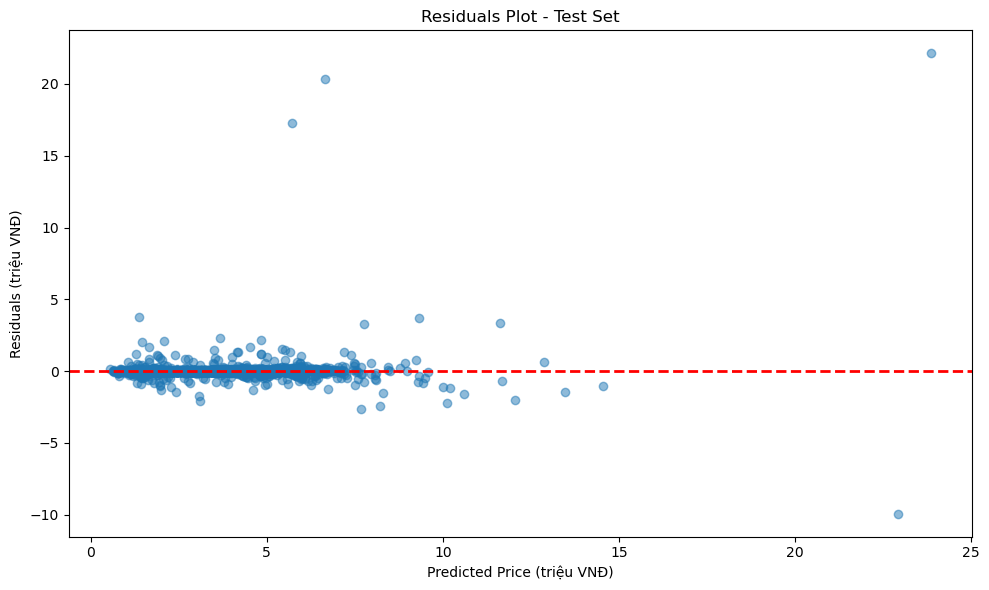

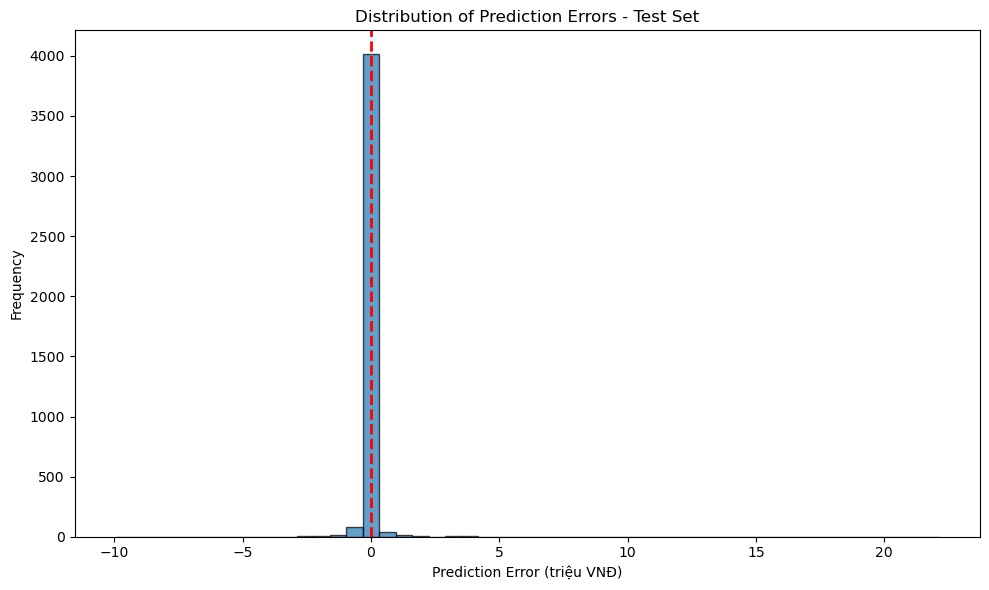

In [37]:
# 9.1 Feature Importance Plot
plt.figure(figsize=(12, 8))
top_n = 20
top_features = feature_importance.head(top_n)
plt.barh(range(len(top_features)), top_features['importance'])
plt.yticks(range(len(top_features)), top_features['feature'])
plt.xlabel('Importance Score')
plt.title(f'Top {top_n} Feature Importances - XGBoost')
plt.gca().invert_yaxis()
plt.tight_layout()

# 9.2 Actual vs Predicted - Test Set
plt.figure(figsize=(10, 6))
plt.scatter(y_test_original, y_pred_test_original, alpha=0.5)
plt.plot([y_test_original.min(), y_test_original.max()], 
         [y_test_original.min(), y_test_original.max()], 
         'r--', lw=2, label='Perfect Prediction')
plt.xlabel('Actual Price (triệu VNĐ)')
plt.ylabel('Predicted Price (triệu VNĐ)')
plt.title(f'Actual vs Predicted - Test Set (R² = {test_metrics["R2"]:.4f})')
plt.legend()
plt.tight_layout()

# 9.3 Residuals Plot
plt.figure(figsize=(10, 6))
residuals = y_test_original - y_pred_test_original
plt.scatter(y_pred_test_original, residuals, alpha=0.5)
plt.axhline(y=0, color='r', linestyle='--', lw=2)
plt.xlabel('Predicted Price (triệu VNĐ)')
plt.ylabel('Residuals (triệu VNĐ)')
plt.title('Residuals Plot - Test Set')
plt.tight_layout()

# 9.4 Error Distribution
plt.figure(figsize=(10, 6))
plt.hist(residuals, bins=50, edgecolor='black', alpha=0.7)
plt.xlabel('Prediction Error (triệu VNĐ)')
plt.ylabel('Frequency')
plt.title('Distribution of Prediction Errors - Test Set')
plt.axvline(x=0, color='r', linestyle='--', lw=2)
plt.tight_layout()